<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Pytorch_logo.png/800px-Pytorch_logo.png" alt="alt text" width="400" height="100">

<h2> Training, Validation and Testing </h2>

In [18]:
import torch
import torchvision
import torch.nn as nn

import time
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# Create some data similar to the intro notebook
num_training_data = 1000
num_validation_data = 500
num_test_data = 200

# Define the mean and covariance for two random data distributions
class_1_cov = torch.FloatTensor([[1.0, 0.25], [0.25, 1.4]])
class_1_mu = torch.FloatTensor([[1, -1.5]])

class_2_cov = torch.FloatTensor([[2, -0.5], [-0.5, 1]])
class_2_mu = torch.FloatTensor([[-2, -3]])

In [20]:
# Create Training Data
class_1_train_data = torch.randn(num_training_data, 2)
class_1_train_data = torch.mm(class_1_train_data, class_1_cov) + class_1_mu

class_2_train_data = torch.randn(num_training_data, 2)
class_2_train_data = torch.mm(class_2_train_data, class_2_cov) + class_2_mu

class_1_train_labels = torch.zeros(num_training_data, 1)
class_2_train_labels = torch.ones(num_training_data, 1)

train_data = torch.cat((class_1_train_data, class_2_train_data), 0)
train_labels = torch.cat((class_1_train_labels, class_2_train_labels), 0)

Text(0.5, 1.0, 'Training Data')

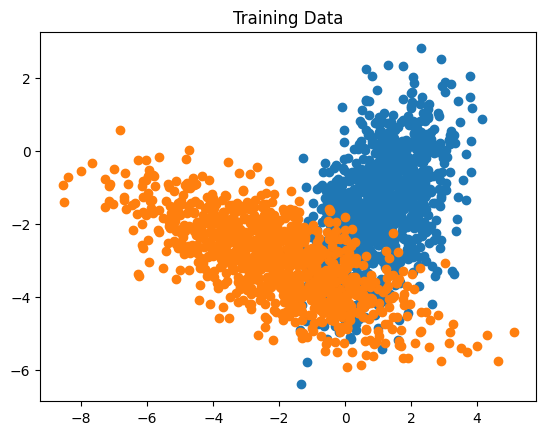

In [21]:
# Visualize the two training data distributions
plt.scatter(class_1_train_data[:, 0], class_1_train_data[:, 1])
plt.scatter(class_2_train_data[:, 0], class_2_train_data[:, 1])
plt.title("Training Data")

In [22]:
# Create Validation Data
class_1_val_data = torch.randn(num_validation_data, 2)
class_1_val_data = torch.mm(class_1_val_data, class_1_cov) + class_1_mu

class_2_val_data = torch.randn(num_validation_data, 2)
class_2_val_data = torch.mm(class_2_val_data, class_2_cov) + class_2_mu

class_1_val_labels = torch.zeros(num_validation_data, 1)
class_2_val_labels = torch.ones(num_validation_data, 1)

val_data = torch.cat((class_1_val_data, class_2_val_data), 0)
val_labels = torch.cat((class_1_val_labels, class_2_val_labels), 0)

Text(0.5, 1.0, 'Validation Data')

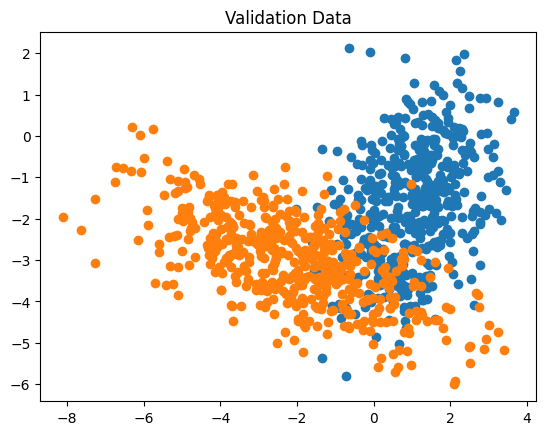

In [23]:
# Visualize the two validation data distributions
plt.scatter(class_1_val_data[:, 0], class_1_val_data[:, 1])
plt.scatter(class_2_val_data[:, 0], class_2_val_data[:, 1])
plt.title("Validation Data")

In [24]:
# Create Test Data
class_1_test_data = torch.randn(num_test_data, 2)
class_1_test_data = torch.mm(class_1_test_data, class_1_cov) + class_1_mu

class_2_test_data = torch.randn(num_test_data, 2)
class_2_test_data = torch.mm(class_2_test_data, class_2_cov) + class_2_mu

class_1_test_labels = torch.zeros(num_test_data, 1)
class_2_test_labels = torch.ones(num_test_data, 1)

test_data = torch.cat((class_1_test_data, class_2_test_data), 0)
test_labels = torch.cat((class_1_test_labels, class_2_test_labels), 0)

Text(0.5, 1.0, 'Test Data')

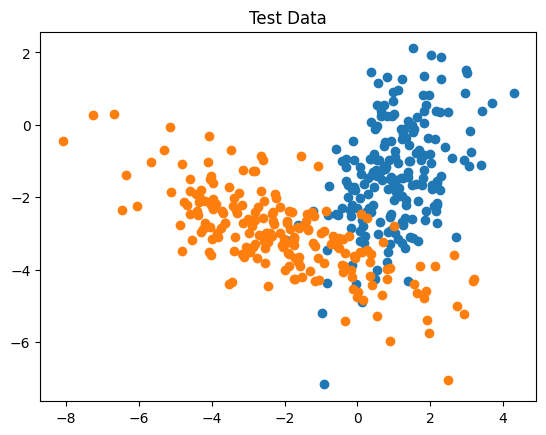

In [25]:
# Visualize the two testing data distributions
plt.scatter(class_1_test_data[:, 0], class_1_test_data[:, 1])
plt.scatter(class_2_test_data[:, 0], class_2_test_data[:, 1])
plt.title("Test Data")

<h4>Training Function </h4>
Create a function that performs a single step of gradient decent

In [26]:
# Function to perform a single step of gradient decent
def training_step(data_batch, target_batch, model, optimizer, loss_func):
    target_pred = model(data_batch)
    loss = loss_func(target_pred, target_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

<h4>Evaluation Function </h4>
Create a function that calculates how many of the models predictions were correct

In [27]:
def eval_step(data_batch, target_batch, model):
    with torch.no_grad():
        target_pred = model(data_batch)
        predictions = (target_pred >= 0)

        num_correct = (predictions == target_batch).sum()

        return num_correct.item()

<h4>Training/Eval Loop</h4>
Instead of using ALL of the data for every gradient calculation, the dataset into "mini batches" are going to randomly splited up and a step of gradient decent on each of these is performed.
Performing this "mini-batched" stocastic gradient decent is not nessisary here as the model and dataset are small. However in cases where each data-point is large (like an image) and the dataset contains many datapoints, it is not possible to store all of the inputs/outputs, hidden layers, parameters and datapoints in memory all at once.
For example, the Image-net dataset contains over 1 million images and a suitable (but small) Neural Network like ResNet18 has over 11 million Parameters!

<h4>Train/Val/Test split</h4>
When trying to assess the performance of the model it is important that the same data can not be used when train the model! There is a very good chance that some level of "overfitting" has occured and the performance of the model on some "unseen" data will be different. Therefore, some of the avaliable data must be withheld and not used for training. Instead, it can be used to validate the performance of the model during training. This "validation set" is used during training to asses the performace of the model and to "tune" the hyperparameters to get good performance, but it can not be used for gradient decent.
Interestingly, the process of hyperparameter tuning is itself an optimization process. Therefore in the hyperparameters of the system are "trained" on the validation set.

In [28]:
# Function to calulate the accuracy of the model for the given data and labels
def eval_loop(eval_data, eval_targets, model, batch_size):

    # Reshape into mini-batches, for eval the data is not required to shuffle
    eval_batches = eval_data.split(batch_size, 0)
    eval_label_batches = eval_targets.split(batch_size, 0)

    total_correct = 0

    # zip allows to loop over mulitple iterables at the same time
    for (data, target) in zip(eval_batches, eval_label_batches):
        num_correct = eval_step(data, target, model)
        total_correct += num_correct

    return total_correct/eval_data.shape[0]


# Function to perform the training loop
def training_loop(train_data, train_targets, val_data, val_targets, model, optimizer,
                  loss_func, num_epochs=100, batch_size=50):

    loss_logger = []
    val_accuracy_logger = []
    train_accuracy_logger = []

    # A single loop over the whole dataset is called an "epoch"
    for epoch in range(num_epochs):
        val_acc = eval_loop(val_data, val_targets, model, batch_size)
        val_accuracy_logger.append(val_acc)

        train_acc = eval_loop(train_data, train_targets, model, batch_size)
        train_accuracy_logger.append(train_acc)

        # Create random indices to shuffle the data
        rand_indx = torch.randperm(train_data.shape[0])

        # Shuffle the data and targets with the same random indices and reshape into mini-batches
        data_batches = train_data[rand_indx].split(batch_size, 0)
        target_batches = train_targets[rand_indx].split(batch_size, 0)

        # zip allows to loop over mulitple iterables at the same time
        for (data, target) in zip(data_batches, target_batches):
            # Loop over the mini batches and perform a step of gradient decent every time
            loss = training_step(data, target, model, optimizer, loss_func)
            loss_logger.append(loss)

    return loss_logger, train_accuracy_logger, val_accuracy_logger

<h4>Setup </h4>
Create the model, optimizer and loss function the same as before

In [29]:
linear = nn.Linear(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear.parameters(), lr=0.001)
num_epochs = 400
batch_size = 200

<h4> Train </h4>

In [30]:
start_time = time.time()
loss_logger, train_acc, val_acc = training_loop(train_data, train_labels, val_data, val_labels,
                                                linear, optimizer, loss_function,
                                                num_epochs=num_epochs, batch_size=batch_size)

print("Traing for %d epochs with a batch size of %d took %.2f seconds" %
      (num_epochs, batch_size, time.time() - start_time))

Traing for 400 epochs with a batch size of 200 took 1.72 seconds


Graph out the training loss and the accuracy

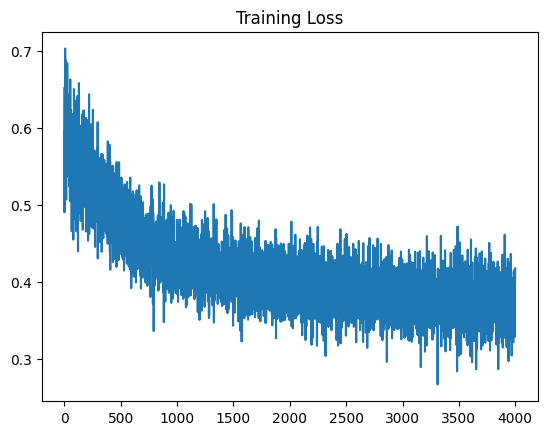

In [31]:
plt.plot(loss_logger)
_ = plt.title("Training Loss")

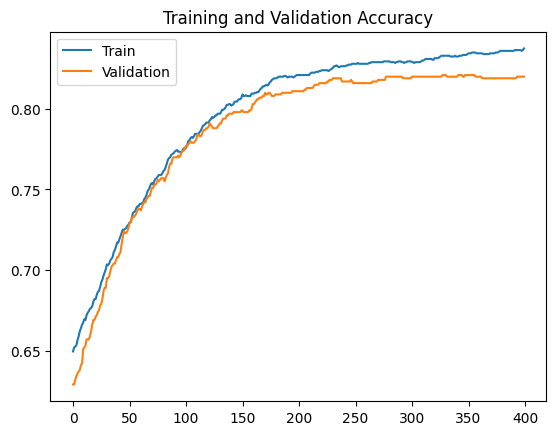

In [32]:
plt.plot(train_acc)
plt.plot(val_acc)
_ = plt.title("Training and Validation Accuracy")
plt.legend(["Train", "Validation"])

In [33]:
test_accuracy = eval_loop(test_data, test_labels, linear, batch_size=50)
print("Test Accuracy is %.2f%%" % (100 * test_accuracy))

Test Accuracy is 83.75%
